<a href="https://colab.research.google.com/github/NisaRimi/Shoe_classification/blob/main/Shoe_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Define the data directory
data_dir = '/content/drive/MyDrive/dataset'


In [65]:
os.listdir(data_dir)

['labelnames.csv', 'train', 'test', 'validation']

In [78]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [79]:
# Create image datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}


In [ ]:
# from google.colab import drive
# from torchvision import datasets, transforms
# import os

# # Mount Google Drive
# drive.mount('/content/drive')

# # Correct the data directory based on your folder structure
# data_dir = '/content/drive/MyDrive/dataset'  # Adjust the path if needed

# # Define your data transformations (example)
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#     ]),
#     'validation': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#     ]),
# }

# # Create image datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 460, 'validation': 55}


['adidas', 'nike']

In [81]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [83]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 0.7444 Acc: 0.6848
validation Loss: 0.8338 Acc: 0.6545
train Loss: 0.6237 Acc: 0.7109
validation Loss: 0.5525 Acc: 0.7273
train Loss: 0.7334 Acc: 0.7087
validation Loss: 0.7846 Acc: 0.6727
train Loss: 0.5720 Acc: 0.7239
validation Loss: 1.0018 Acc: 0.6364
train Loss: 0.6978 Acc: 0.7304
validation Loss: 0.9295 Acc: 0.6364
train Loss: 0.6086 Acc: 0.7152
validation Loss: 0.5501 Acc: 0.7818
train Loss: 0.5863 Acc: 0.7413
validation Loss: 0.5888 Acc: 0.7273
train Loss: 0.5091 Acc: 0.7609
validation Loss: 0.5437 Acc: 0.7818
train Loss: 0.5437 Acc: 0.7630
validation Loss: 0.8218 Acc: 0.6909
train Loss: 0.5460 Acc: 0.7696
validation Loss: 0.6466 Acc: 0.7273
Training complete!


In [85]:
# Save the model
torch.save(model.state_dict(), 'shoe_classification_model.pth')

Classification on Unseen Image

In [86]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('shoe_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

<ipython-input-86-a3db5fd83275>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('shoe_classification_model.pth'))


In [137]:
# Load and preprocess the unseen image
image_path = '/content/Adidas (47).jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [138]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['Nike', 'Adidas']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: Adidas


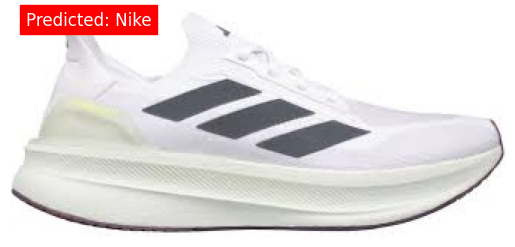

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()